<a href="https://colab.research.google.com/github/yukiao/Pengantar-Deep-Learning/blob/main/Week5/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of the AlexNet architecture on PyTorch based on the reference from https://github.com/dansuh17/alexnet-pytorch/blob/d0c1b1c52296ffcbecfbf5b17e1d1685b4ca6744/model.py#L40

In [88]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from datetime import datetime

# Configuration

Here we initialize some variables that we will use when training and testing the model

In [138]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 20
BATCH_SIZE = 128
CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Architecture

The implementation of Alex Net is implemented here

In [90]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=1000):
    super().__init__()
    
    self.net = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels=96, kernel_size=11, stride=4, padding=2),
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(96, 256, 5, padding=2),
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(256, 384, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(384, 384, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(384, 256, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2)
    )

    self.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear((256*6*6),4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Linear(4096, num_classes),
    )
    
    self.init_bias()

  def init_bias(self):
    for layer in self.net:
      if isinstance(layer, nn.Conv2d):
        nn.init.normal_(layer.weight, mean=0, std=0.01)
        nn.init.constant_(layer.bias,0)
    nn.init.constant_(self.net[4].bias, 1)
    nn.init.constant_(self.net[10].bias, 1)
    nn.init.constant_(self.net[12].bias, 1)

  def forward(self, x):
    x = self.net(x)
    x = x.view(-1, 256 * 6 * 6)
    return self.fc(x)

# Helper Function

Here we define some helper function that we can use to simplify the code

In [91]:
# Get accuracy on training
def get_accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [92]:
def train(model, train_loader, criterion, optimizer, device):
  model.train()
  running_loss = 0

  for X, y_true in train_loader:
    optimizer.zero_grad()

    X = X.to(device)
    y_true = y_true.to(device)

    # Forward pass
    y_hat = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

    # Backward pass
    loss.backward()
    optimizer.step()
  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

In [94]:
def training_loop(model, criterion, optimizer, train_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    print("Start Training")
    print(f"Using {device} device")
    # Train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(model, train_loader, criterion, optimizer, device)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Loss: {train_loss:.4f}\t'
                  f'Accuracy: {100 * train_acc:.2f}%\t')
    
    print("Finish")
    return model, optimizer

In [152]:
def imshow(img, title, index):
  plt.subplot(1,5,index)
  plt.axis('off')
  img = img / 2 + 0.5
  npimg = img.numpy()
  npimg = np.clip(npimg, 0,1)
  plt.title(title)
  plt.imshow(np.transpose(npimg, (1,2,0)))

# Training

It's the time to train the model. First we create the dataset that we are going to use throughout the process. Here we will use CIFAR10 dataset that consist of 10 different classes

In [96]:
train_dataset = datasets.CIFAR10("./data",
                                 train=True,
                                 transform = transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                                         std=(0.247, 0.243, 0.261))
                                 ]),
                                 download = True)

test_dataset = datasets.CIFAR10("./data",
                                 train = False,
                                 transform = transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                                         std=(0.247, 0.243, 0.261))
                                 ]),
                                 download = True)

Files already downloaded and verified
Files already downloaded and verified


Next, we define the train loader so that we can train our model in some batches

In [97]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

Here we define the AlexNet model that we are going to use. Also we use Adam optimizer for this project rather than SGD that is used in original paper. For calculating loss we will use CrossEntropyLoss 

In [98]:
model = AlexNet(num_classes=10).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
# optimizer = optim.SGD(
#     params=model.parameters(),
#     lr=LR_INIT,
#     momentum=0.9,
#     weight_decay=0.0005
#     )
criterion = nn.CrossEntropyLoss()

We train our model using the training_loop function. Here we train our model using 10 epochs. We only use 10 epochs rather than 90 epochs because the training  time will be to long if we use 90 epochs. With 10 epochs, the training time is about 1.5 hours.

In [99]:
model, optimizer = training_loop(model, criterion, optimizer, train_loader, NUM_EPOCHS, device)

Start Training
Using cuda device
14:07:09 --- Epoch: 0	Loss: 2.0681	Accuracy: 39.28%	
14:11:59 --- Epoch: 1	Loss: 1.5393	Accuracy: 50.75%	
14:16:50 --- Epoch: 2	Loss: 1.3064	Accuracy: 60.11%	
14:21:41 --- Epoch: 3	Loss: 1.1184	Accuracy: 65.76%	
14:26:33 --- Epoch: 4	Loss: 0.9763	Accuracy: 72.38%	
14:31:24 --- Epoch: 5	Loss: 0.8606	Accuracy: 75.83%	
14:36:15 --- Epoch: 6	Loss: 0.7557	Accuracy: 81.27%	
14:41:08 --- Epoch: 7	Loss: 0.6740	Accuracy: 84.42%	
14:46:00 --- Epoch: 8	Loss: 0.5944	Accuracy: 86.90%	
14:50:53 --- Epoch: 9	Loss: 0.5150	Accuracy: 90.41%	
14:55:46 --- Epoch: 10	Loss: 0.4482	Accuracy: 93.16%	
15:00:39 --- Epoch: 11	Loss: 0.3876	Accuracy: 95.74%	
15:05:32 --- Epoch: 12	Loss: 0.3289	Accuracy: 96.89%	
15:10:24 --- Epoch: 13	Loss: 0.2766	Accuracy: 96.90%	
15:15:17 --- Epoch: 14	Loss: 0.2370	Accuracy: 99.15%	
15:20:09 --- Epoch: 15	Loss: 0.2032	Accuracy: 99.21%	
15:25:01 --- Epoch: 16	Loss: 0.1812	Accuracy: 99.45%	
15:29:55 --- Epoch: 17	Loss: 0.1596	Accuracy: 99.57%	
15:34

## Save model

In this part of codes, we use the save method from torch so that we don't need to train the model again if we close the google colab tab.

In [103]:
torch.save(model.state_dict(), "/content/drive/MyDrive/CNNModels/alexnet.pth")

## Load Model

We load the saved model so that we can use that immediately for testing

In [106]:
alex_net = AlexNet(10).to(device)
alex_net.load_state_dict(torch.load("/content/drive/MyDrive/CNNModels/alexnet.pth"))

<All keys matched successfully>

# Testing

Same as the training phase, here we define the test loader 

In [187]:
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

We test the model with the test dataset. After that we calculate the accuracy on test dataset. Unforunately, the accuracy is significantly decrease. Based on that, we conclude that our model is overfitting

In [195]:
alex_net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = alex_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} test images: {format(100 * correct / total)} %')
	 

Accuracy of the network on the 10000 test images: 79.59 %


# Visualization

Finally, we will visualize some prediction on test dataset using the model that we have defined

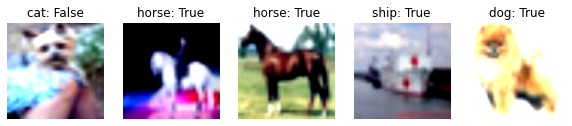

In [203]:
import torchvision
inputs, classes = next(iter(test_loader))
original_inputs = inputs
original_classes = classes

inputs = inputs.to(device)
classes = classes.to(device)

correct = 0

fig = plt.figure(figsize=(10,10))
for i in range(5):
  with torch.no_grad():
    alex_net.eval()
    output = alex_net(inputs[i].reshape(1,3,224,224))
    out = output.cpu().data.numpy().argmax()
    predicted = CLASSES[out]
    correct = out == classes[i].item()
    imshow(original_inputs[i], predicted+f": {correct}", i+1)

plt.show()